#### Script to plot firing rate between dot offset and reward delivery for each neuron in a session.

**Prerequisites**
- Install python environment 'spikeinterface_fnt'
- Run script to create a data frame with harp timestamps aligned to key behavioral events.
- Run spike sorting pipeline for the session of interest.
- (If aligning firing rate to behavioral events): run 'get_harp_timestamps_df.py' on the required session

**Inputs:**
- Output from Kilosort spike-sorting in a subfolder (specified by the user) within the session folder.
- Raw Open-ephys data within session folder.
- (If aligning firing rate to behavioral events): Data frame with harp timestamps of relevant behavioral events

**Key outputs**
- Plot firing rate calculated via various alternative sliding windows

**Overview** 
1. Read in sorting output for a given session
2. Extract spike times for all "good" units (according to spike sorting)
3. Take firing rate over a sliding window (of length specified by the user, via 
    (i) a rectangular sliding window
    (ii) a Gaussian sliding window


**Configure directory parameters**

In [13]:
import os
import glob
import spikeinterface.core as sc
import numpy as np

#==============================================================================
# animal_ID = 'FNT101'
# session_ID = '2024-01-29T11-28-52'    # 2 channels: 'Messages', 'Neuropixels PXI Sync'            -> Only TTL pulse

animal_ID = 'FNT098'
# session_ID = '2024-03-26T12-55-01'    #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat
# # GOOD SESSIONS:
session_ID = '2024-04-08T14-25-33'    #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat
# session_ID = '2024-04-09T15-30-41'    #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat
# session_ID ='2024-04-11T10-45-55'     #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat
# session_ID = '2024-04-12T12-21-50'    #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat

# animal_ID = 'FNT099'
# GOOD SESSIONS:
#session_ID = '2024-05-12T10-46-59'     #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> Only heartbeat
#session_ID = '2024-05-13T11-03-59'     #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> Only heartbeat
#session_ID = '2024-05-14T10-03-49'     #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> Only heartbeat
#session_ID = '2024-05-15T11-33-15'     #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat
#session_ID = '2024-05-16T09-45-06'     #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat
#session_ID = '2024-05-17T10-12-40'     #2 channels: 'Messages', 'PXIe-6341Digital Input Line'    -> TTL pulse + heartbeat
# EXTRA SESSIONS FOR STAGE 4.1 (to be used if TTL pulse cannot be recovered in previous sessions)
# session_ID = '2024-05-23T11-18-50' 
# session_ID = '2024-05-28T11-22-55'
# session_ID = '2024-05-30T09-18-29'


# path behavioral data on ceph repo
# This assumes a directory structure generated from raw experimental data 
# outputs
input_root_dir = "W:/projects/FlexiVexi/behavioural_data"

# path to data analysis root directory
# NOTE: this directory structure is generated by running analysis code offline.
# This could either be generated in a local directory or a directory on the ceph 
# repo
analysis_root_dir = "W:/projects/FlexiVexi/Data Analysis"

# name of subfolder in session folder with desired Kilosort output
kilosort_subfolder = 'Kilosort3'
#==============================================================================

**Import recording and sorting info for session**

In [17]:
import spikeinterface.extractors as se

# Get session folder from input root directory
session_folder = os.path.join(input_root_dir, animal_ID, session_ID)

# Path to Kilosort output files within session folder
kilosort_folder = os.path.join(session_folder, kilosort_subfolder, 'sorter_output')

# Get output from spike sorting using Kilosort, keeping only good units (according to Kilosort's criteria)
sorting = se.read_kilosort(folder_path=kilosort_folder,keep_good_only=True)
print(sorting)

# Get path to Open-Ephys Record Node within session folder
matching_files = glob.glob(os.path.join(session_folder, '**', 'settings.xml'), recursive=True)
if matching_files:
    # Get the first matching file
    first_matching_file = matching_files[0]

    # Get the directory of the first matching file
    path_to_recording = os.path.dirname(first_matching_file)
else:
    print("No 'settings.xml' file found in " + session_folder)
        
# Get recording from open ephys
recording = se.read_openephys(folder_path=path_to_recording, stream_name = 'Record Node 102#Neuropix-PXI-100.ProbeA')

# Get NI-DAQ recording from open ephys
#recording = se.read_openephys(folder_path=path_to_recording, stream_name = 'NI-DAQmx-103.PXIe-6341')

KiloSortSortingExtractor: 111 units - 1 segments - 30.0kHz


**Inspect events in Open-Ephys recording**

We should have two unique labels in 'events': 
- '1' denotes the heartbeat pulse every second (duration 0.5 seconds). This is used to check whether any frames are dropped by the neuropixels probe.
- '4' denotes a TTL pulse. This essential for aligning ephys and behavioural data via the harp.

In [15]:
# Read open ephys event times
#path_to_recording = 'W:/projects/sequences/test_subject/test_2024-08-07_16-02-47_001'
event = se.read_openephys_event(folder_path=path_to_recording)

# Get number event channels
print('Number of channels: ' + str(event.get_num_channels()))

# Get channel IDs of event channels:
print('Event channel IDs: ' + str(event.channel_ids))
# Take the second channel ID. This should be 
#  - 'PXIe-6341Digital Input Line' for recordings taken with NI-DAQ
#  - 'Neuropixels PXI Sync' for recordings taken before using NI-DAQ (e.g. FNT101)
PXI_channel_ID = event.channel_ids[1] 
events = event.get_events(channel_id=PXI_channel_ID)

# Get unique values in event_info_PXI labels
unique_labels = np.unique(events['label'])
print('Unique labels: ' + str(unique_labels))

Number of channels: 2
Event channel IDs: ['Messages' 'PXIe-6341Digital Input Line']
Unique labels: ['1' '4']


**Plot raster of spikes for n units**

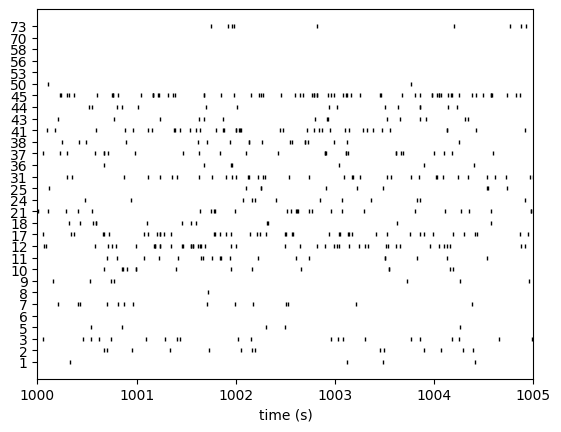

In [18]:
import spikeinterface.widgets as sw

n=30
unit_ids = sorting.get_unit_ids()

# Plot rasters for first n units in unit_ids
w_rs = sw.plot_rasters(sorting, time_range=(1000, 1005), unit_ids=unit_ids[:n])

# Get event timestamps in ephys clock time


**Plot firing rate over time of an example neuron from a rectangular sliding window**

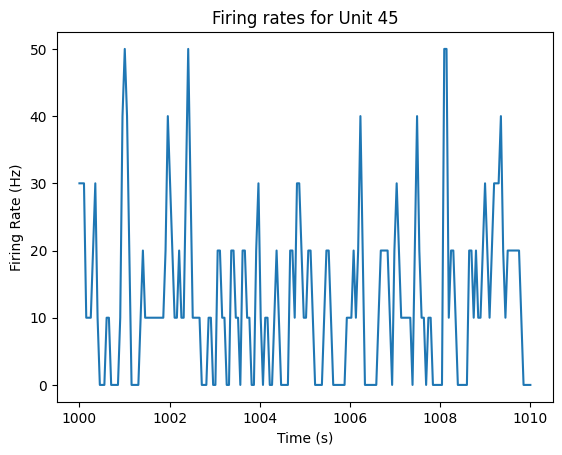

In [21]:
#------------------------------------------------------------------------------
# USER CONFIGURATION
#------------------------------------------------------------------------------

## Define the specific unit ID for which to calculate the firing rate
specific_unit_id = 45  # Replace with the desired unit ID

## Define duration of each window in seconds
window_size = 0.1   # 100ms window
overlap = 0.5   # 50% overlap

## Specify times over which sliding window should be applied to calculate  
##  changes in firing rate should be calculated.
t_start=1000
t_end=1010

#==============================================================================

# Retrieve the entire spike train for the specific unit
spike_times = sorting.get_unit_spike_train(unit_id=specific_unit_id, return_times=True)

# Create window times with 50% overlap
total_duration = t_end - t_start
window_step = window_size * overlap  # 50 % overlap
num_windows = int(np.ceil(total_duration / window_step))
window_times = [(i * window_step, i * window_step + window_size) for i in range(num_windows)]

# Align window times to spike times by adding recording start time
window_times = [(start + min(spike_times), end + min(spike_times)) for start, end in window_times]

# Compute firing rates for each window for the specific unit ID
firing_rates_per_window = []
for start, end in window_times:

    # Filter spikes within the current window
    window_spike_train = spike_times[(spike_times >= start) & (spike_times < end)]

    # Compute firing rate
    firing_rate = len(window_spike_train) / window_size
    firing_rates_per_window.append(firing_rate)

# Plot firing rates over time
import matplotlib.pyplot as plt
time_vector = np.linspace(t_start, t_end, num_windows)
plt.plot(time_vector, firing_rates_per_window)
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing rates for Unit {}'.format(specific_unit_id))
plt.show()

**Plot firing rate over time of example unit over Gaussian sliding window $w$**

Plot the firing rate of an example unit over a Gaussian sliding window $w$, where the kernel $w(t)$ applied to calculate the firing rate at time $t$ is of the form:
$$
w(t) = \frac{1}{\sqrt{2\pi} \sigma_{w}} \exp\left( -\frac{t^2}{2\sigma_{w}^2} \right),
$$
In which $\sigma_{w}$ determines the temporal resolution of the firing rate.

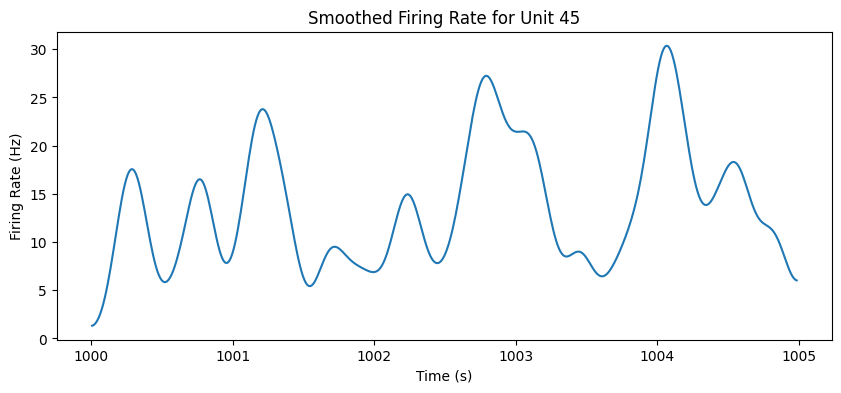

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

#------------------------------------------------------------------------------ 
# USER CONFIGURATION 
#------------------------------------------------------------------------------ 

## Define the specific unit ID for which to calculate the firing rate 
specific_unit_id = 45  # Replace with the desired unit ID

## Define standard deviation for the Gaussian kernel
sigma = 0.1 # Standard deviation of 100 ms

# Time step between consecutive samples. 
time_step = 0.01  # 1 ms

## Specify times over which sliding window should be applied to calculate  
##  changes in firing rate should be calculated. 
t_start = 1000 
t_end = 1005

#============================================================================== 

# Retrieve the entire spike train for the specific unit 
spike_times = sorting.get_unit_spike_train(
    unit_id=specific_unit_id, 
    return_times=True
    )

# Create a time vector from t_start to t_end with a fine resolution
time_vector = np.arange(t_start, t_end, time_step)

# Count the number of spikes within each bin of the time vector
spike_counts, bin_edges = np.histogram(spike_times, bins=time_vector)
spike_counts = list(spike_counts)
float_counts = [float(x) for x in spike_counts]

# Apply Gaussian filter to the binary spike train
# note: divide by time_step to convert from spikes per frame (time step) to Hz
smoothed_firing_rate = gaussian_filter1d(float_counts, sigma=sigma/time_step)/time_step

# Plot the smoothed firing rate
plt.figure(figsize=(10, 4))

# Take the center of the bin as the time point for plotting
plt.plot(bin_edges[0:-1]+time_step/2, smoothed_firing_rate)

plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.title(f'Smoothed Firing Rate for Unit {specific_unit_id}')
plt.show()

**Align firing rate to a behavioral event**

To align firing rate to specific behavioral events, you first need to run 'get_harp_timestamps_df.py' to generate a data frame with timestamps from the harp aligned by trials. 

This data frame is saved as a .pkl file in the data analysis directory structure under the specified root folder 'analysis_root_folder'.

In [ ]:
import pickle

# Define variables
analysis_root_dir = "W:/projects/FlexiVexi/Data Analysis"
animal_ID = 'FNT099'
session_ID = '2024-05-13T11-03-59'

# Get filepath for pickle file containing trial data with harp timestamps
session_dir = os.path.join(analysis_root_dir, 'intermediate_variables', animal_ID, session_ID)
filename = animal_ID + '_' + session_ID + '_trial_data_harp.pkl'

# check files in session directory
files = os.listdir(session_dir)
print(files)
filepath = os.path.normpath(os.path.join(session_dir, filename)) # make sure file separators are consistent

# Check if the file exists
if not os.path.exists(filepath):
    print(f"No such file or directory: '{filepath}'")

# Load trial data from pickle file
with open(filepath, 'rb') as f:
    trials_df = pickle.load(f)